# NEURON Tutorial: The Tsodyks-Markram model of synapse dynamics

## Introduction

In this tutorial, we will interactively augment the AMPA and NMDA model of glutamate receptors we saw in the previous tutorial with a model of synapse dynamics, the Tsodyke-Markram model, as described in:

G. Fuhrmann, I. Segev, H. Markram, M. Tsodyks. Coding of Temporal Information by Activity-Dependent Synapses. J. Neurophysiol. 2002, 87(1) 140-148; DOI: 10.1152/jn.00258.2001

In doing so, you will learn how to implement the mathematical formulations of the model into NMODL syntax, and gain a deeper understanding of this widely used formulation of synapse dynamics. 

## Edit the MOD file

As before, the definition of the synapse model is in a MOD file.  Let's now interactively augment this MOD file to account for synapses dynamics according to the Tsodyks-Markram model.

Again, we will use the embedded editing capabilities of Jupyter.

## Compiling MOD files

MOD files need to be compiled before they can be used with NEURON.  
NEURON provides a tool called "nrnivmodl", which has the syntax:
```bash
$ nrnivmodl <directory>
```
Invocation will compile all `.mod` files found in `<directory>`, if specified, otherwise the current directory.

Our `.mod` file is located in "`mechanisms`", so we compile it as follows (the prefix `!` is used to invoke a system call outside python):

In [1]:
!nrnivmodl  mechanisms


/home/jovyan
mechanisms
mechanisms
make: *** No rule to make target 'mechanisms.mod', needed by 'mechanisms.lo'.  Stop.


## nrnivmodl: Verify successful compilation

The output above indicates `nrnivmodl` completed successfully.  If error messages are generated, then something maybe wrong in your `.mod` file program.  Double-check your .mod file, and try again. 

## Trying out your new synapse model

If your .mod files are compiled before you import neuron, NEURON will load your compiled models automatically if they are in your local directory.

In [2]:
import neuron
from neuron import h
import numpy
import matplotlib.pyplot as plt
# Load external files & initialize
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

If you forgot to compile your .mod files before importing neuron, you can trigger NEURON to load them as follows.  Note, this command can only be executed once for a given directory of .mod files.  Executing it a second time will crash your jupyter kernel.  

In [3]:
#neuron.load_mechanisms(".")

## A neuron to host your synapse

Following previous exercises, we will create a single compartment soma neuron to host the synapse.

In [4]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

In [5]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

Create the synapse at the center of the soma compartment

In [6]:
synapse = h.TsodyksMarkram_AMPA_NMDA(soma(0.5))

Define the stimulus: 8 spikes at 20Hz + 1 spike 500 ms later

In [7]:
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

Create a recorder for the synaptic conductance, current, the soma voltage, the time intervals, and Use and R

In [8]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)
R_syn = h.Vector()
R_syn.record(synapse._ref_R)
Use_syn = h.Vector()
Use_syn.record(synapse._ref_Use)

1.0

Let's configure biologically plausible values for the AMPA and NMDA model parameters

In [9]:
synapse.gmax_AMPA = 0.002 # uS
synapse.gmax_NMDA = 0.7 * 0.002 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0 # mM

Now let's configure parameters for pseudo linear synapse dynamics (E3), and simulate

In [10]:
synapse.U1 = 0.2 # Baseline release probability
synapse.tau_rec = 200 # ms - recovery from depression
synapse.tau_facil = 200 # ms - relaxation from facilitation

h.tstop = 1000.0 # ms
neuron.h.run()

0.0

<IPython.core.display.Javascript object>


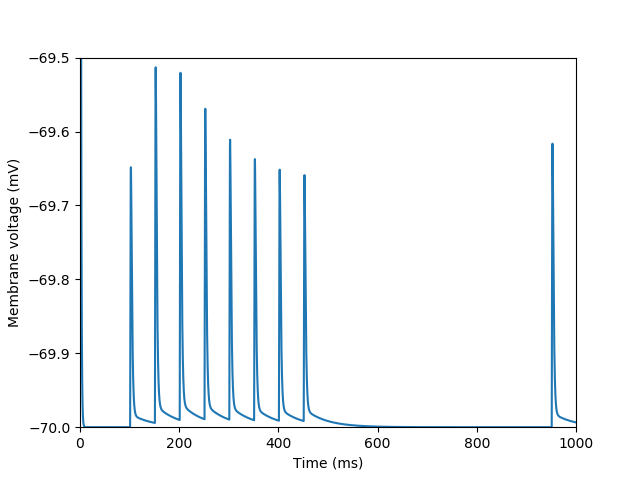

[0, 1000, -70, -69.5]

In [11]:
# This command gives us fancy interactive inline plots
%matplotlib notebook

def plot_timecourse(time_array, dependent_var, newfigure=True, show=True, label=None, ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    if show:
        plt.show()
        
plot_timecourse(time, v_soma)
plt.axis([0, 1000, -70, -69.5])

<IPython.core.display.Javascript object>


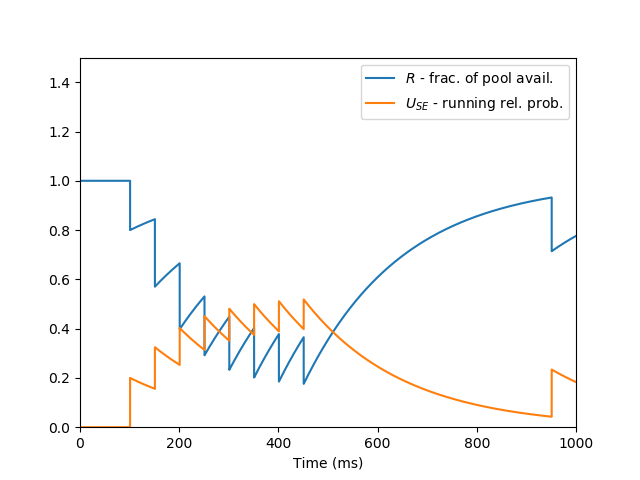

<IPython.core.display.Javascript object>


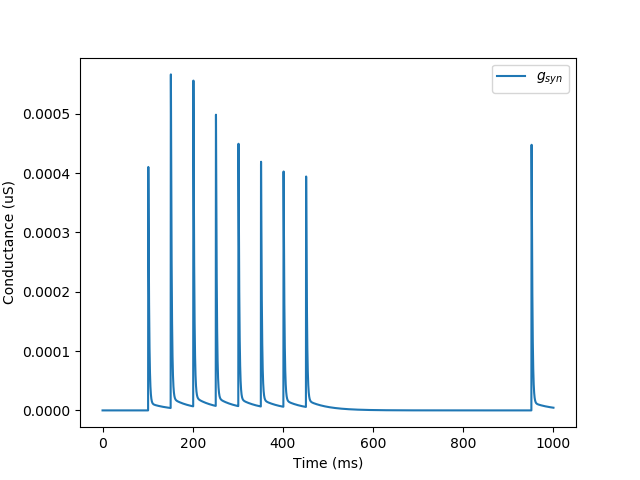

In [12]:
plot_timecourse(time, R_syn, ylabel="", label="$R$ - frac. of pool avail.")
plot_timecourse(time, Use_syn, ylabel="", label="$U_{SE}$ - running rel. prob.", newfigure=False)
plt.legend()
plt.axis([0,1000,0,1.5])
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="$g_{syn}$")
plt.legend()

Now, let's configure a depressing synapse (E2).  Such synapses have a higher baseline release probability, a longer recovery time from depression, and a very short relaxation time of facilitation. 

In [13]:
synapse.U1 = 0.5 # Baseline release probability
synapse.tau_rec = 700 # ms - recovery from depression
synapse.tau_facil = 10 # ms - relaxation from facilitation

neuron.h.run()

0.0

<IPython.core.display.Javascript object>


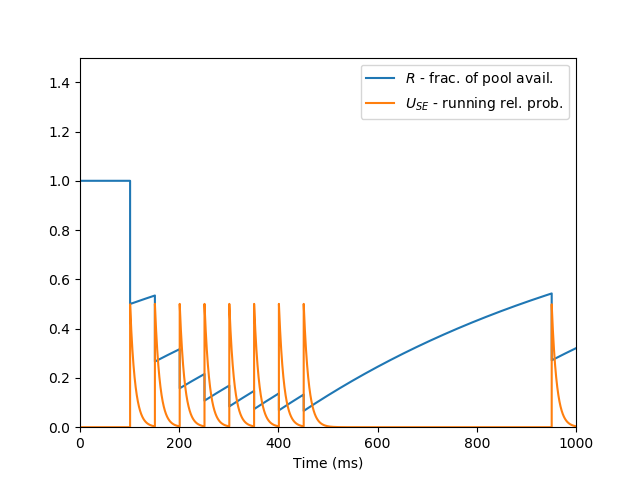

<IPython.core.display.Javascript object>


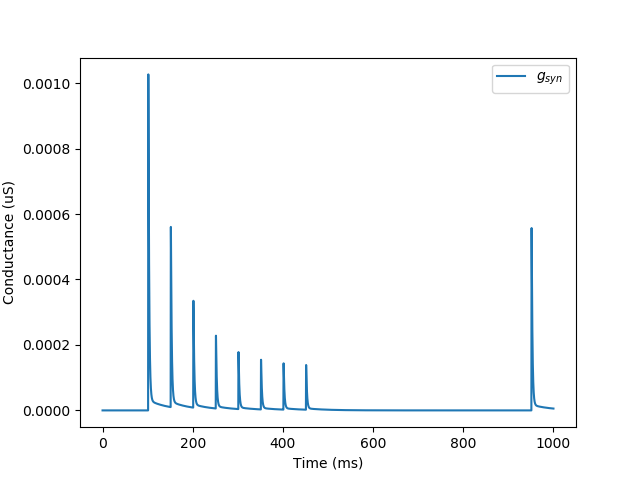

In [14]:
plot_timecourse(time, R_syn, ylabel="", label="$R$ - frac. of pool avail.")
plot_timecourse(time, Use_syn, ylabel="", label="$U_{SE}$ - running rel. prob.", newfigure=False)
plt.legend()
plt.axis([0,1000,0,1.5])
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="$g_{syn}$")
plt.legend()